# Example 4: Confidence intervals

## Retrieve data and obtain posterior log-rate map

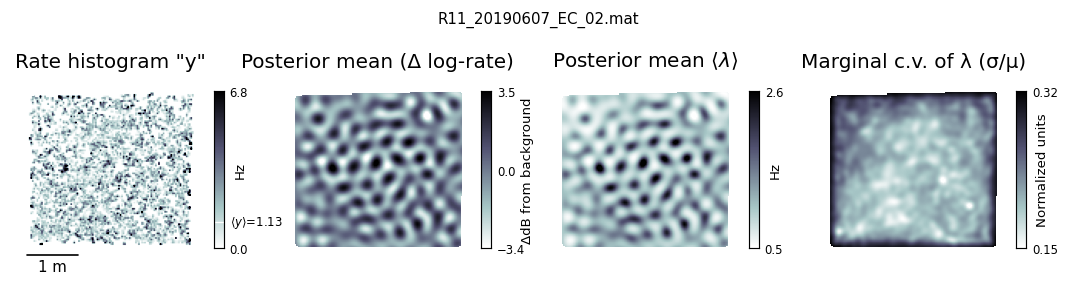

In [9]:
import sys
sys.path.append('../')
from lgcpspatial.load_data import Dataset
from lgcpspatial.lgcp2d    import DiagonalFourierLowrank, coordinate_descent
from lgcpspatial.plot      import *

# Load dataset R11_20190607_EC_02
L        = 128 # Grid size for position bins
pad      = 0.1 # Edge padding (Avoids circular convolution wrap-around)
dataset  = 'R11_20190607_EC_02.mat'
fn       = '../example data/' + dataset
data     = Dataset.from_file(fn,pad)
data.prepare(L)

# Infer using optimized parameters
# These parameters were computed in example 3
P        = 11.50 # Grid period
kv       = 0.103 # Log-rate prior covariance kernel peak variance (zero lag variance)
model    = DiagonalFourierLowrank(kv,P,data)
fit      = coordinate_descent(model,tol=1e-3)
low_rank_posterior_mean,posterior_variance,vfe = fit
inference_summary_plot(model,
    data.arena.mask,
    data.y,
    low_rank_posterior_mean,
    data.prior_mean,
    posterior_variance,
    data.position_sample_rate,
    L,
    data.scale,
    dataset);

## Confidence intervals via sampling or quadratic approximation

(2, 66)


Text(0.5, 1.0, 'Quadratic')

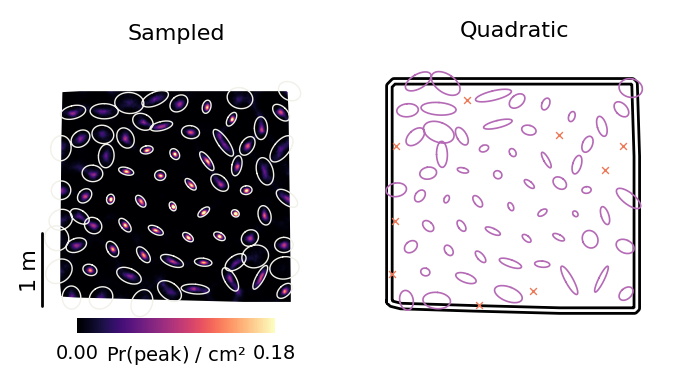

In [10]:
from lgcpspatial.posterior import SampledConfidence, QuadraticConfidence

resolution          = 2      # Upsampling resolution
exclusion_radius    = P/2    # Limit field radius/collisions
nsamples            = 1000   # Number of samples
localization_radius = P*0.75 # Drop peaks with confidence outside this radius

figure(figsize=(4,2),dpi=200)
subplot(121)
confidence = SampledConfidence(
    data,                 # Dataset
    model,                # Model
    fit,                  # Fitted result
    exclusion_radius,     # Use local maxima within this radius
    resolution,           # Updampling
    nsamples,             # Samples to use
    height_threshold=0.6, # Amplitude threshold for peaks
    prpeak_threshold=0.6, # Fraction of samples peak must be present to include
    doplot=True,
    color=WHITE,
    cmap='magma')
title('Sampled')

subplot(122)
# Confidence intervals directly from the posterior:
# A locally-quadratic approximation of the peak, disrupted 
# by the expected gradient of the posterior covariance, is 
# sufficient for getting confidence intervals for well-
# localized peaks. 
confidence = QuadraticConfidence(
    data,                 # Dataset
    model,                # Model
    fit,                  # Fitted result
    exclusion_radius,     # Use local maxima within this radius
    localization_radius,  # Drop poorly-localized peaks
    height_threshold=0.6, # Amplitude threshold for peaks
    doplot=True)
title('Quadratic')

## Joint confidence ellipses (experimental) 

(2, 66)


Text(0.5, 1.0, 'Quadratic (teal:joint, purple:independent)')

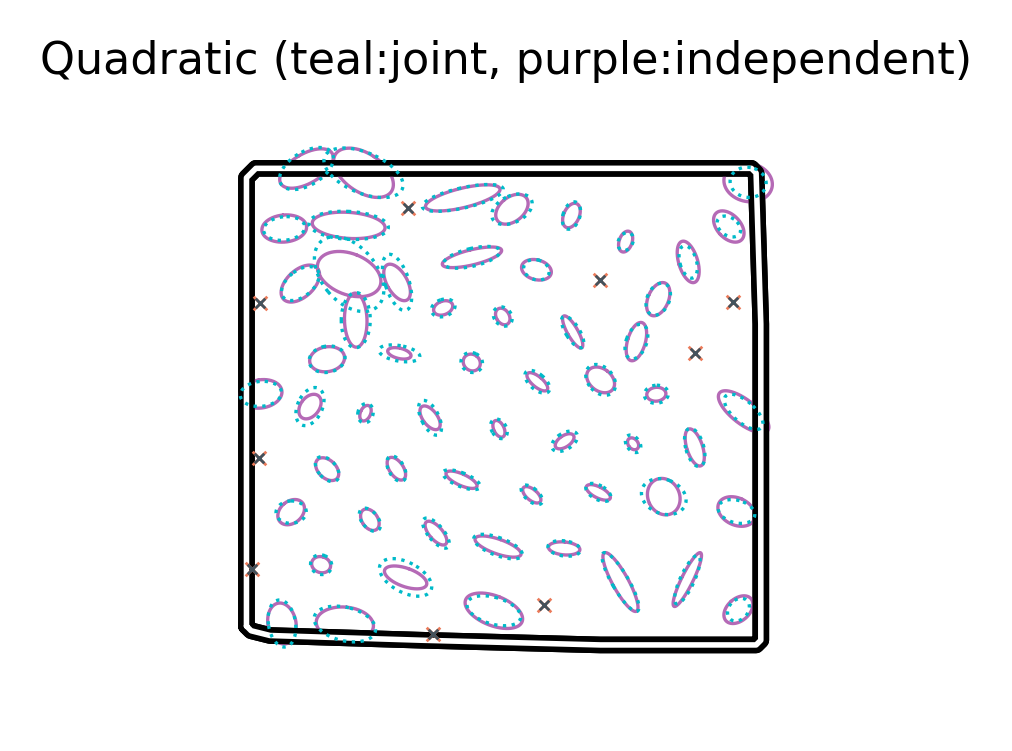

In [12]:
from lgcpspatial.posterior import QuadraticConfidenceJoint

figure(figsize=(2,2),dpi=400)
# Confidence intervals directly from the posterior:
# A locally-quadratic approximation of the peak, disrupted 
# by the expected gradient of the posterior covariance, is 
# sufficient for getting confidence intervals for well-
# localized peaks. 
confidence = QuadraticConfidence(
    data,                 # Dataset
    model,                # Model
    fit,                  # Fitted result
    exclusion_radius,     # Use local maxima within this radius
    localization_radius,  # Drop poorly-localized peaks
    height_threshold=0.5, # Amplitude threshold for peaks
    doplot=True)

# Confidence intervals directly from the posterior:
# A locally-quadratic approximation of the peak, disrupted 
# by the expected gradient of the posterior covariance, is 
# sufficient for getting confidence intervals for well-
# localized peaks. 
confidence = QuadraticConfidenceJoint(
    data,                 # Dataset
    model,                # Model
    fit,                  # Fitted result
    exclusion_radius,     # Use local maxima within this radius
    localization_radius,  # Drop poorly-localized peaks
    height_threshold=0.5, # Amplitude threshold for peaks
    doplot=True,
    color=TEAL,linestyle=':')
title('Quadratic (teal:joint, purple:independent)')